#Violence Detection using transfer learning






In [ ]:
%matplotlib inline

##EDA

###data sets:


1.   [RWF2000 - A Large Scale Video Database for Violence Detection](https://github.com/mchengny/RWF2000-Video-Database-for-Violence-Detection)
2.   [Hockey Fight Detection Dataset](https://academictorrents.com/details/38d9ed996a5a75a039b84cf8a137be794e7cee89/tech)
3.   [Movies Fight Detection Dataset](https://academictorrents.com/details/70e0794e2292fc051a13f05ea6f5b6c16f3d3635) 
4.    [Crowd Violence / violent-flows database](https://www.openu.ac.il/home/hassner/data/violentflows/)

5.     [cctv](https://www.kaggle.com/shreyj1729/cctv-fights-dataset)
6.     [surv](https://github.com/sayibet/fight-detection-surv-dataset)
7.    [rose-lab NTU CCTV-Fights Dataset](http://rose1.ntu.edu.sg/Datasets/cctvFights.asp)


### Sampling video frames

In [ ]:
import glob
import cv2
from tqdm.notebook import tqdm

fils = glob.glob("*")
for file in tqdm(fils):
  vidcap = cv2.VideoCapture(file)
  success,image = vidcap.read()
  count = 0
  while success:
    if (count%10 ==9 ):
      cv2.imwrite("out/framee%s_%d.jpg" % (file.split('.')[0], count), image)     # save frame as JPEG file      
    success,image = vidcap.read()
    # print('Read a new frame: ', success)
    count += 1

###Train-Test split

In [ ]:
import os
from pathlib import Path
import shutil
import random
val_size = 0.2
val_dir = Path('val/')
train_dir = Path('train/')
for entry in train_dir.iterdir():
  images = [f for f in entry.iterdir()]
  size = len(images)
  randoms = set()
  for i in range(int(size*val_size)):
    random_image = random.choice(images)
    while random_image in randoms:
      random_image = random.choice(images)
    randoms.add(random_image)
    dest_dir = val_dir/entry.name
    dest_dir.mkdir(parents=True, exist_ok=True)
    shutil.move(random_image, dest_dir/random_image.name)

##Train model

###prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/datasets/rahneshan

/content/gdrive/.shortcut-targets-by-id/1WqPSYqUZu_VPxIgSO4t4Fs6VyD1EGywg/rahneshan


####import **libraries**

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm
import torch.nn.functional as nnf

plt.ion()   # interactive mode

####Load Data






#####transforms


Data augmentation and normalization for training

Just normalization for validation

mor possible transforms are in comments

In [ ]:
# https://pytorch.org/docs/stable/torchvision/transforms.html
# torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
# torchvision.transforms.Grayscale(num_output_channels=1)
# torchvision.transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, resample=0, fillcolor=0)
# torchvision.transforms.RandomGrayscale(p=0.1)
# torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=2, fill=0)
# torchvision.transforms.RandomRotation(degrees, resample=False, expand=False, center=None, fill=None)
# torchvision.transforms.RandomVerticalFlip(p=0.5)
# torchvision.transforms.GaussianBlur(kernel_size, sigma=(0.1, 2.0))
# torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#####load data in dataloader

In [ ]:
data_dir = 'frames'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
fight_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
fight_dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
fight_class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
ls frames/train/NonFight | wc -l

15272


In [ ]:
ls frames/train/fight | wc -l

16312


In [ ]:
ls frames/val/NonFight | wc -l

3818


In [ ]:
ls frames/val/fight | wc -l

4077


In [ ]:
device

device(type='cuda', index=0)

####visulize some data

In [ ]:
def imshow(inp, size, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(size,size))
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

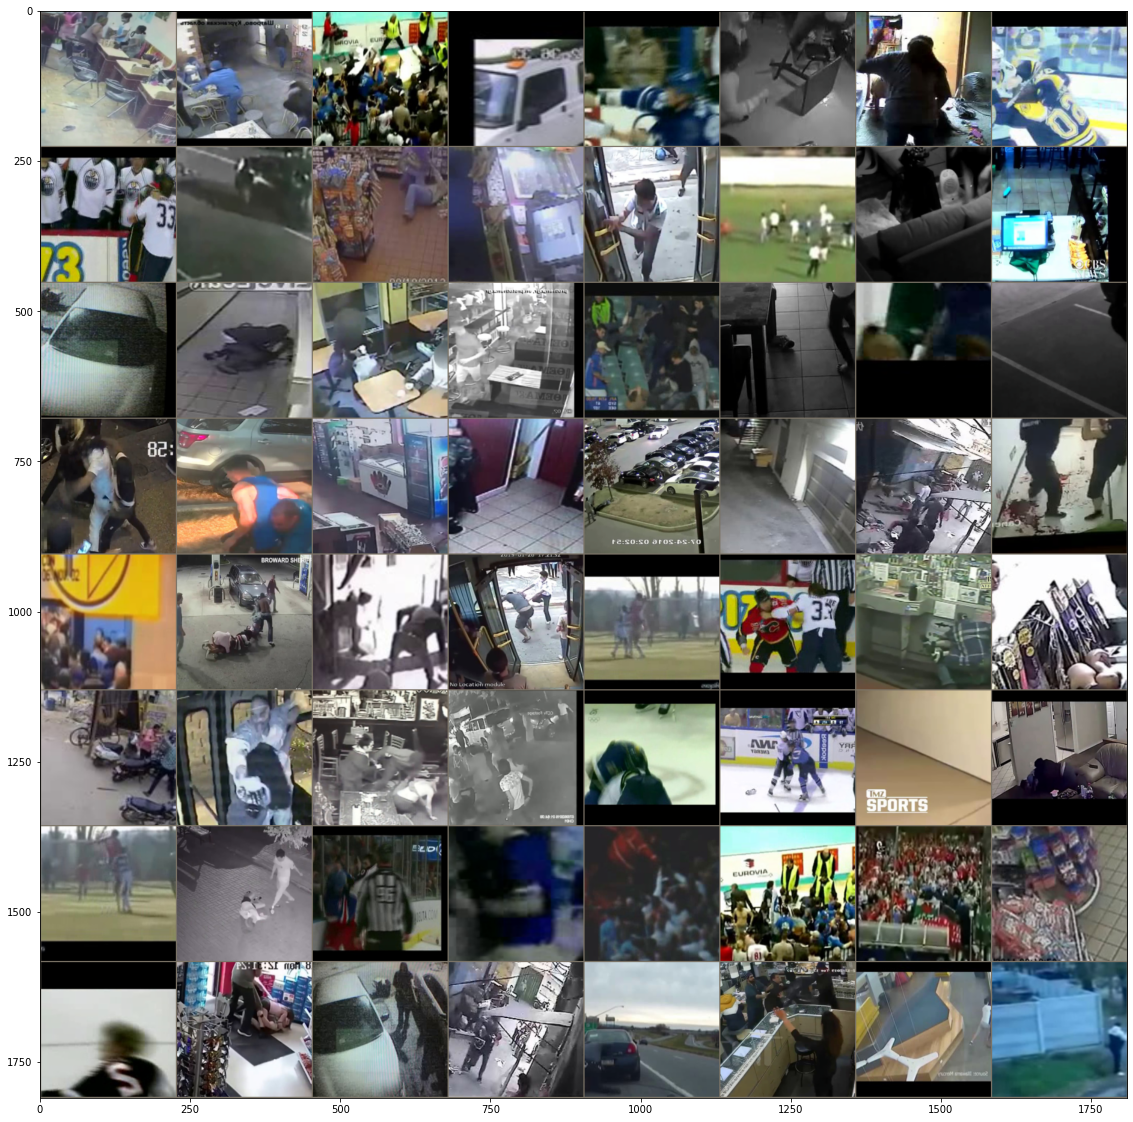

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(fight_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, 20 , title=[fight_class_names[x] for x in classes])

##Training the model

-  Scheduling the learning rate
-  Return the best model




In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # for inputs, labels in dataloaders[phase]:
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model_n(model , dataloaders, class_names):
    was_training = model.training
    model.eval()
    images_so_far = 0
    

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            fig = plt.figure()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = nnf.softmax(outputs, dim=1)
            top_2, top2_class = prob.topk(2, dim = 1)

            # ----------------------------------
            fig = plt.figure(figsize=(28, 28))
            columns = 4
            rows = 5

            # prep (x,y) for extra plotting
            xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
            ys = np.abs(np.sin(xs))           # absolute of sine

            # ax enables access to manipulate each of subplots
            ax = []
            for i in range(columns*rows):
                j = i
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                # create subplot and append to ax
                ax.append( fig.add_subplot(rows, columns, i+1) )
                title = 'predicted: '+ str(class_names[top2_class[j][0]]) + '\n' + str(class_names[top2_class[j][0]]) +' prob: '+ str(format(top_2[j][0], 'f')) + '\n' + str(class_names[top2_class[j][1]]) + ' prob: '+ str(format(top_2[j][1], 'f'))
                ax[-1].set_title(title)  # set title
                plt.axis("off")
                plt.imshow(inp)
            model.train(mode=was_training)
            return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_fight = models.resnet18(pretrained=True)
# model_fight = models.resnet50(pretrained=True)
num_ftrs = model_fight.fc.in_features

model_fight.fc = nn.Linear(num_ftrs, len(fight_class_names))

model_fight = model_fight.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_fight.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
model_fight = train_model(model_fight, criterion, optimizer_ft, exp_lr_scheduler,
                       fight_dataloaders, fight_dataset_sizes, num_epochs=15)

Epoch 0/14
----------



train Loss: 0.4384 Acc: 0.7880



val Loss: 0.3445 Acc: 0.8443

Epoch 1/14
----------



train Loss: 0.3074 Acc: 0.8621



val Loss: 0.2049 Acc: 0.9178

Epoch 2/14
----------



train Loss: 0.2468 Acc: 0.8955



val Loss: 0.1541 Acc: 0.9406

Epoch 3/14
----------



train Loss: 0.2108 Acc: 0.9100



val Loss: 0.1214 Acc: 0.9529

Epoch 4/14
----------



train Loss: 0.1888 Acc: 0.9192



val Loss: 0.1127 Acc: 0.9544

Epoch 5/14
----------



train Loss: 0.1687 Acc: 0.9284



val Loss: 0.0854 Acc: 0.9664

Epoch 6/14
----------



train Loss: 0.1568 Acc: 0.9350



val Loss: 0.0928 Acc: 0.9612

Epoch 7/14
----------



train Loss: 0.1313 Acc: 0.9471



val Loss: 0.0742 Acc: 0.9681

Epoch 8/14
----------



train Loss: 0.1237 Acc: 0.9498



val Loss: 0.0698 Acc: 0.9705

Epoch 9/14
----------



train Loss: 0.1237 Acc: 0.9492



val Loss: 0.0681 Acc: 0.9715

Epoch 10/14
----------



train Loss: 0.1172 Acc: 0.9514



val Loss: 0.0673 Acc: 0.9719

Epoch 11/14
----------



train Loss: 0.1135 Acc: 0.9536



val Loss: 0.0663 Acc: 0.9730

Epoch 12/14
----------



train Loss: 0.1118 Acc: 0.9530



val Loss: 0.0628 Acc: 0.9756

Epoch 13/14
----------



train Loss: 0.1140 Acc: 0.9529



val Loss: 0.0598 Acc: 0.9769

Epoch 14/14
----------



train Loss: 0.1101 Acc: 0.9559



val Loss: 0.0601 Acc: 0.9768

Training complete in 110m 2s
Best val Acc: 0.976947


In [ ]:
torch.save(model_fight, 'fight_model')

In [ ]:
model = torch.load('fight_model')


<Figure size 432x288 with 0 Axes>

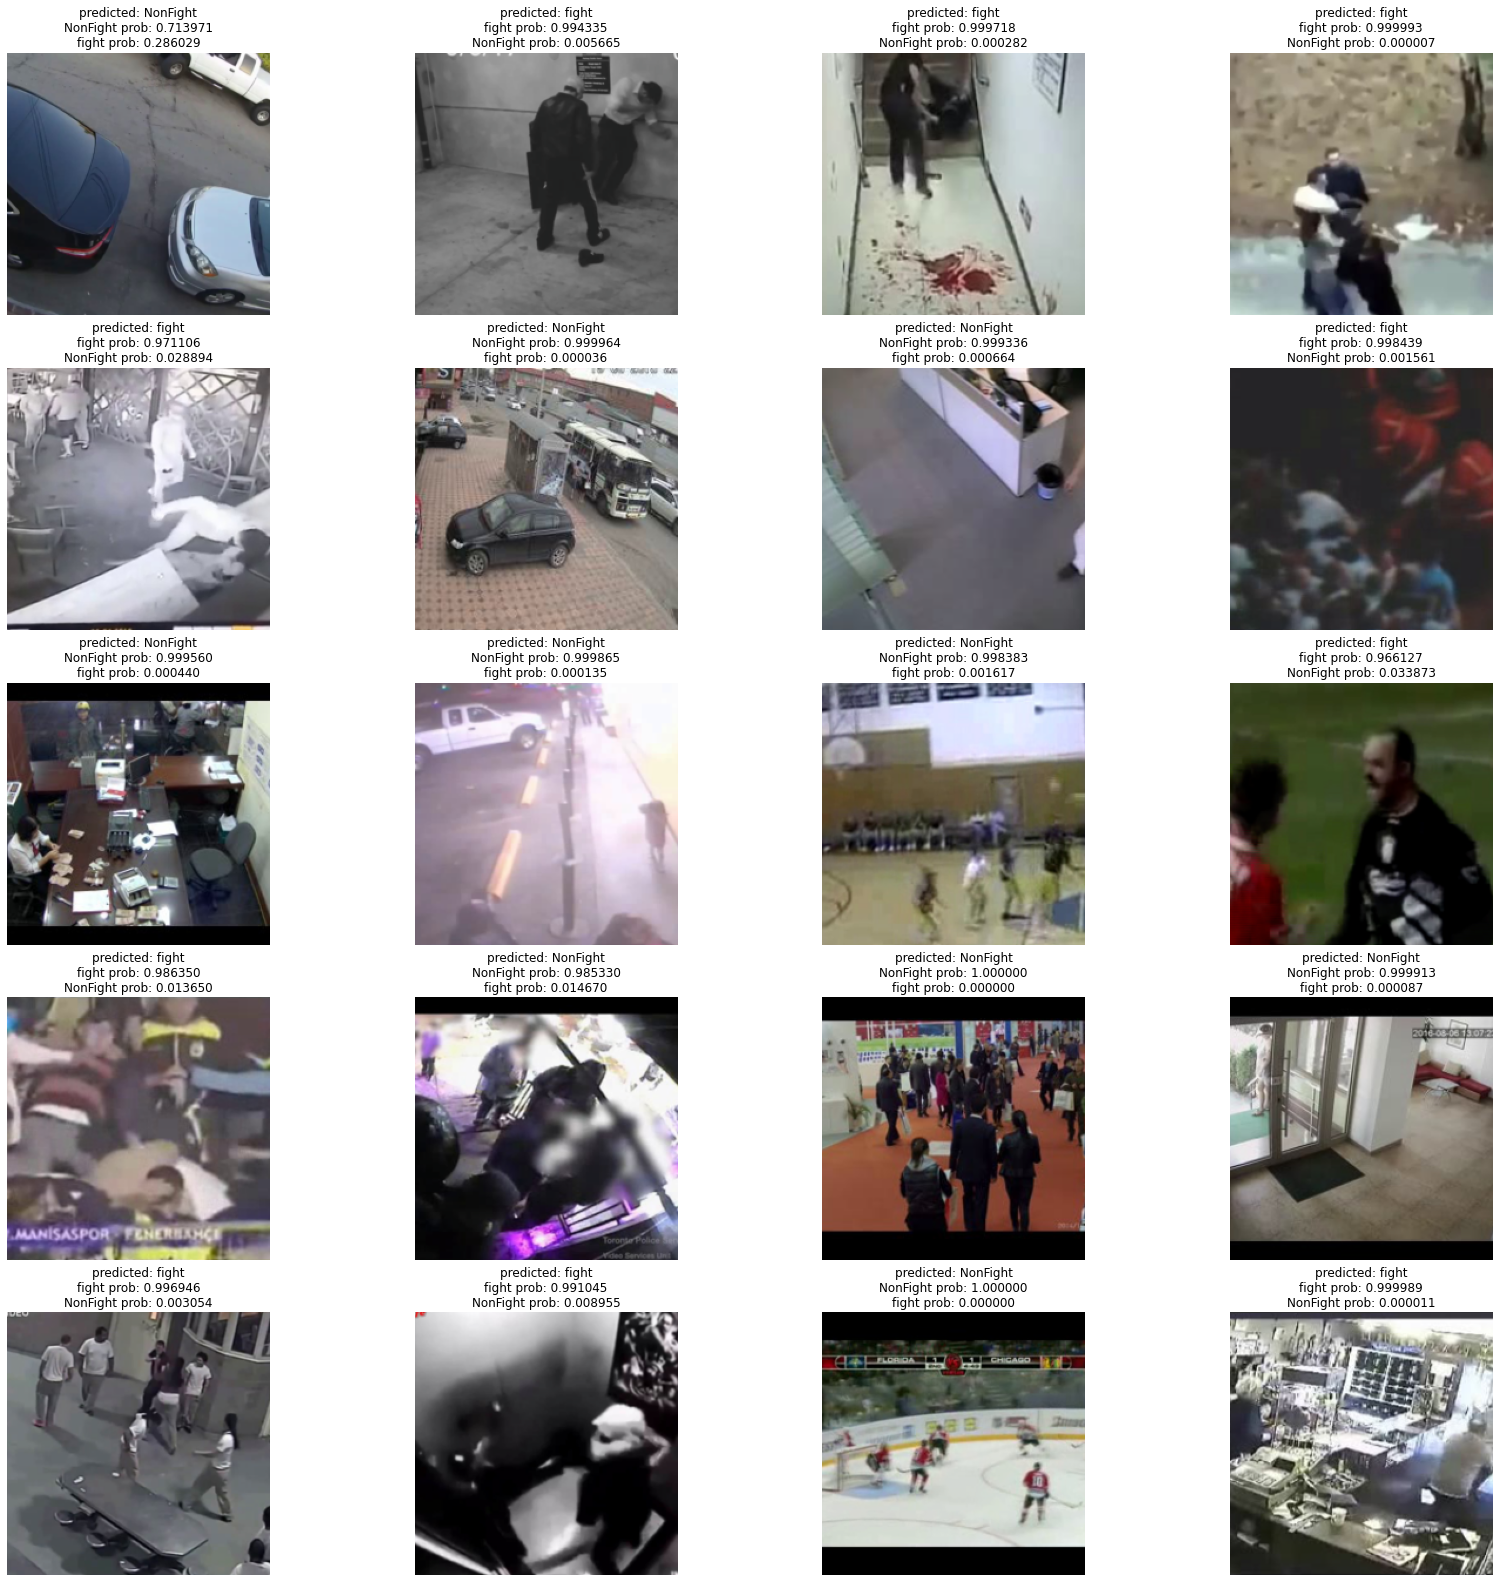

In [ ]:
visualize_model_n(model, fight_dataloaders,fight_class_names)

In [ ]:
import cv2
from PIL import Image
from collections import Counter
path2video = "/content/gdrive/MyDrive/datasets/rahneshan/videoplayback.mp4"
cap= cv2.VideoCapture(path2video)
i=0
main_frames=[]
transformed_frames =[]
predicts = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i % 5 == 4: # this is the line I added to make it only save one frame every 20
          # frame = torch.from_numpy(frame)
          main_frames.append(frame)
          frame = Image.fromarray(frame).convert('RGB')
          frame = data_transforms['val'](frame)
          transformed_frames.append(frame)

    i+=1
print("frames counts: " ,len(main_frames))
video_loader = torch.utils.data.DataLoader(transformed_frames, batch_size=128, shuffle=True, num_workers=8)
was_training = model.training
model.eval()
video_preds = []
video_probs = []
with torch.no_grad():
  for i, inputs in enumerate(video_loader):
      inputs = inputs.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      prob = nnf.softmax(outputs, dim=1)
      top_2, top2_class = prob.topk(2, dim = 1)
      video_preds+= preds.tolist()
      video_probs += prob.tolist()
  model.train(mode=was_training)
most_common = Counter(video_preds).most_common(1)[0][0]
print("predicted class for entire video : ", fight_class_names[most_common])

frames counts:  2285
predicted class for entire video :  fight


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random

# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.axis('off')
ax1.set_xlim(( 0, main_frames[0].shape[1]))
ax1.set_ylim((0, main_frames[0].shape[0]))
ax2.set_xlim(( -1, 2))
ax2.set_ylim((0, 1))

# ims = [plt.imshow(im, animated=True) for im in main_frames]
# print(ims)
image, = [ax1.imshow(np.flipud(main_frames[0]))]
line0, =ax2.bar('nonfight',0)
line1, =ax2.bar('fight',0)
predictions = video_probs


# initialization function: plot the background of each frame
def init():
    line0, =ax2.bar('nonfight',0)
    line1, =ax2.bar('fight',0)
    image, = [ax1.imshow(np.flipud(main_frames[0]))]
    return (line0,line1, image)

# animation function. This is called sequentially
def animate(i):
    line0.set_height(predictions[i][0])
    line1.set_height(predictions[i][1])
    image, = [ax1.imshow(np.flipud(main_frames[i]))]
    return (line0,line1,image)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(predictions), interval=400, blit=True)


In [ ]:
HTML(anim.to_html5_video())

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('im.mp4', writer=writer)